### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

import lightgbm
import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest', 'SVM_rbf', 'SVM_poly', 'LightGBM', 'XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!
Directory already exsist!
Directory already exsist!
Directory already exsist!
Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].transform(impute_mean)

train.drop(['nationality', 'country_of_residence', 'income_s_NaN', 'cdr_sumofboxes',
       'cdr_global', 'moca_total','aceiii_total', 'mmse_total',], axis=1, inplace=True)
test.drop(['nationality', 'country_of_residence', 'income_s_NaN','cdr_sumofboxes',
       'cdr_global','moca_total', 'aceiii_total', 'mmse_total',], axis=1, inplace=True)
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [8]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score', 'mini_sea_total', 'barthel_total', 'pfeffer_total',
       'npi_total', 'npi_total_caregiver', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4',
       'income_s_5', 'income_s_6', 'income_s_7', 'income_s_8', 'income_s_9',
       'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [9]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
train.shape, test.shape

((1450, 34), (161, 34))

In [10]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh


In [11]:
### Load Hyperparams
# hparams_path = "/home/mm/Tesis/pred_results/2023-07-14/mean_hparams/" # ssh

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-08-16/mean_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

rbf_hp = pd.read_csv(hparams_path + "SVC_RBF_hparams2.csv",
                     usecols=['param_C', 'param_gamma','params', 'mean_test_score' ,'mean_train_score'])
rbf_hp= rbf_hp[rbf_hp['mean_test_score'] < rbf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

lgbm_hp = pd.read_csv(hparams_path + "lgbm_hparams.csv", usecols=[ 'param_learning_rate', 'param_max_depth',
       'param_n_estimators', 'param_num_leaves', 'param_reg_alpha',
       'param_reg_lambda','params', 'mean_test_score' ,'mean_train_score'])
lgbm_hp= lgbm_hp[lgbm_hp['mean_test_score'] < lgbm_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "xgb_hparams.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [12]:
rf_hp.iloc[0,:]

param_criterion                                                      entropy
param_max_depth                                                           14
param_max_features                                                        11
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.893385
mean_train_score                                                     0.97627
Name: 0, dtype: object

In [13]:
rbf_hp.iloc[0,:]

param_C                                                      1.748799
param_gamma                                                  0.951544
params              OrderedDict([('C', 1.7487992785641526), ('gamm...
mean_test_score                                              0.872229
mean_train_score                                             0.964839
Name: 0, dtype: object

In [14]:
poly_hp.iloc[0,: ]

param_C                                                      1.020376
param_coef0                                                         0
param_degree                                                        1
param_gamma                                                  4.878415
params              OrderedDict([('C', 1.0203763218807211), ('coef...
mean_test_score                                              0.843835
mean_train_score                                             0.893144
Name: 0, dtype: object

In [15]:
lgbm_hp.iloc[3,:]

param_learning_rate                                             0.046327
param_max_depth                                                       11
param_n_estimators                                                   220
param_num_leaves                                                       5
param_reg_alpha                                                      0.9
param_reg_lambda                                                     0.9
params                 OrderedDict([('learning_rate', 0.0463267416566...
mean_test_score                                                 0.880579
mean_train_score                                                0.969121
Name: 3, dtype: object

In [16]:
xgb_hp.iloc[1, :]

param_booster                                                     gbtree
param_learning_rate                                             0.067163
param_max_bin                                                          6
param_max_depth                                                        8
param_max_leaves                                                      14
param_n_estimators                                                    50
param_reg_alpha                                                      0.5
param_reg_lambda                                                     0.1
param_tree_method                                                 approx
params                 OrderedDict([('booster', 'gbtree'), ('learning...
mean_test_score                                                  0.89773
mean_train_score                                                0.973814
Name: 1, dtype: object

In [17]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[0,'param_n_estimators'],
    "criterion": rf_hp.loc[0,'param_criterion'],
    "max_depth": rf_hp.loc[0,'param_max_depth'],
    "min_samples_split": rf_hp.loc[0,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[0,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[0,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}
#RBF
rbf_params = {'C': rbf_hp.loc[0, "param_C"],
              'gamma': rbf_hp.loc[0, "param_gamma"],
              "kernel":"rbf","class_weight":"balanced", "verbose":0}
#Poly
poly_params = {'C': poly_hp.loc[0, "param_C"],
              'gamma': poly_hp.loc[0, "param_gamma"],
               'coef0': poly_hp.loc[0, "param_coef0"],
               'degree': poly_hp.loc[0, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}
#LGBM
lgbm_params ={'num_leaves': lgbm_hp.loc[3, 'param_num_leaves'],
    'max_depth': lgbm_hp.loc[3, 'param_max_depth'],
    'learning_rate':lgbm_hp.loc[3, 'param_learning_rate'],
    'n_estimators': lgbm_hp.loc[3, 'param_n_estimators'],
    'reg_alpha':lgbm_hp.loc[3, 'param_reg_alpha'],
    'reg_lambda':lgbm_hp.loc[3, 'param_reg_lambda'],
    'subsample':1.0,
    'subsample_freq':-1,
    'objective':'binary',
    'n_jobs': -1,
    'verbose':-1}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[1, 'param_booster'],
    'tree_method': xgb_hp.loc[1, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[1, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[1, 'param_max_depth'],
    'max_bin': xgb_hp.loc[1, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[1, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[1, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[1, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[1, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

In [18]:
n_iter =5000

### RF Model

##### Bootstrap

In [19]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=14, max_features=11, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|████████████████| 5000/5000 [1:21:20<00:00,  1.02it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:81.34445037047068 minutes
empirical p-value: 0.0


In [20]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-08-22/mean_res'

In [21]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.816878
ROC_AUC        0.866244
Precision      0.592843
Recall         0.733217
Sensitivity    0.733217
Specificity    0.842706
F1             0.653945
Efron_pR2      0.274064
dtype: float64

In [22]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.8662


In [23]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010721,0.009435,0.013618,0.012259,0.012259,0.010092,0.013186,0.012364


In [24]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
31,year_birth,0.238612,0.016955
8,ifs_total_score,0.188246,0.014989
32,years_education,0.071418,0.009826
1,ace_lw,0.056832,0.006810
2,ace_vs,0.051929,0.006191
4,cognition,0.048873,0.004562
27,npi_total,0.030779,0.003913
24,moca_lw,0.025602,0.002501
25,moca_vs,0.025591,0.002455
22,mmse_lw,0.024159,0.003426


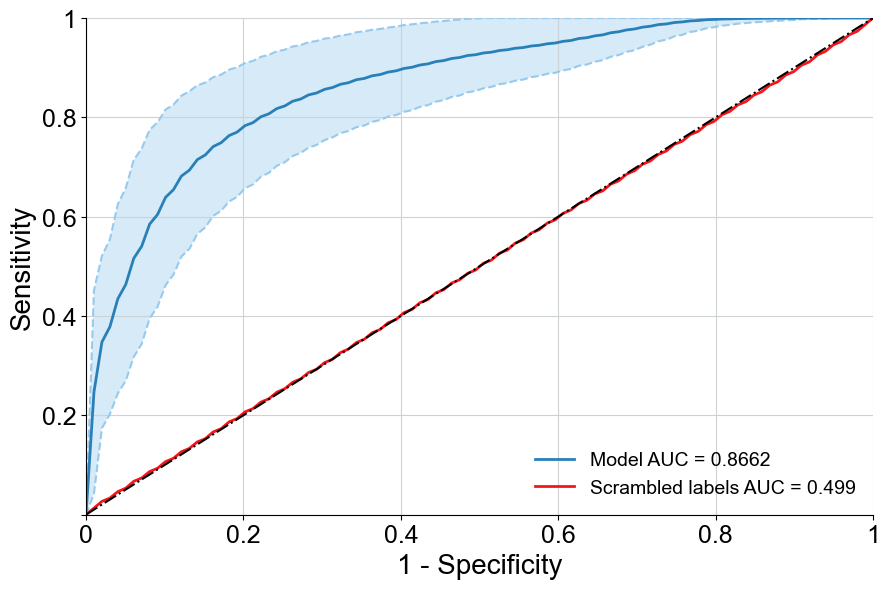

In [25]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve.png")
# Fig save?


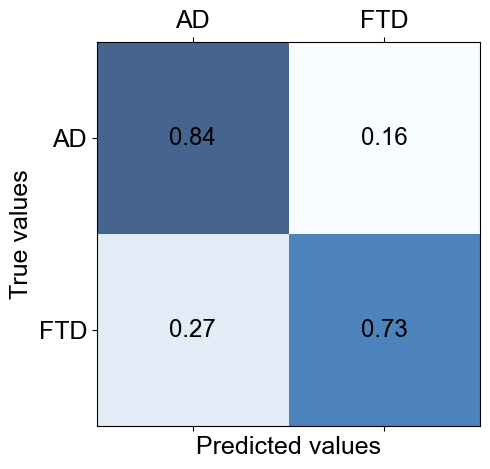

In [26]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [27]:
# rf_fimp = bc.permutation_FIMP( data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.3, n_repeats=1000, random_state=123)

In [28]:
# rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
# rf_fimp.sort_values('mean', ascending=False).head()

In [29]:
# ml_plotting.plot_permutation_FIMP(rf_fimp, names='variables', importances_col='Importance_mean', std_col='Importance_std')

In [30]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
31,year_birth,0.238612,0.016955
8,ifs_total_score,0.188246,0.014989
32,years_education,0.071418,0.009826
1,ace_lw,0.056832,0.006810
2,ace_vs,0.051929,0.006191


##### unseen data

In [31]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [32]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
# cm = np.round(confusion_matrix(y_test, y_pred), 4)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [33]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [34]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8112
Accuracy: 0.8598
Recall: 0.72
F1: 0.7059
Precision:0.6923


In [35]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8112
Bootstrping test ROC score: 	0.8662


### Shapley

In [36]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
shap_values = explainer(X_train, check_additivity=False)

 98%|===================| 1906/1948 [00:39<00:00]        

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


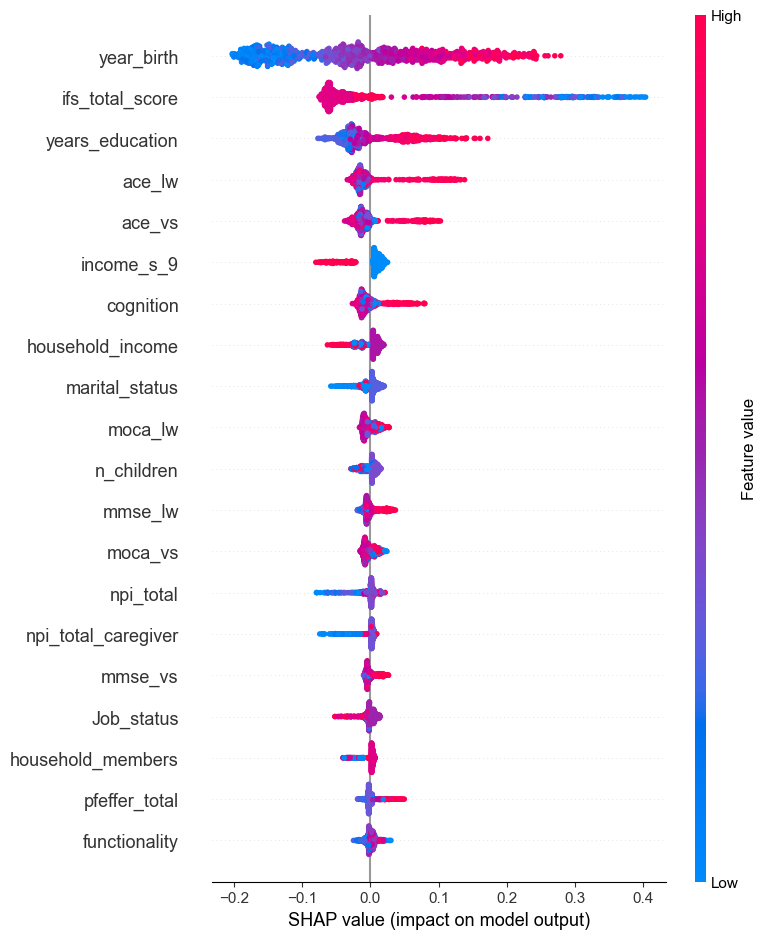

In [37]:
shap.summary_plot(shap_values[:,:,1])

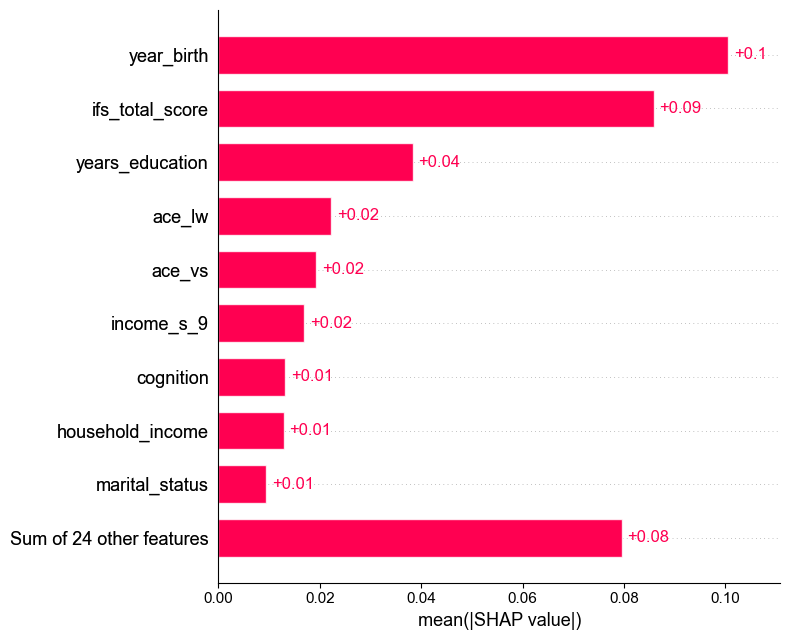

In [38]:
shap.plots.bar(shap_values[:,:,1])

In [39]:
# shap.plots.beeswarm(shap_values[:,:,1])

### SVM - RBF

##### Bootstrap

In [39]:
rbf_Model_res, rbf_CI_df, rbf_Model_res_r, rbf_ROC_AUC, rbf_CM, rbf_ROC_chance, rbf_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=rbf_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

SVC(C=1.7487992785641526, class_weight='balanced', gamma=0.9515437669470558,
    verbose=0)


Iterating: 100%|██████████████████| 5000/5000 [04:07<00:00, 20.16it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:4.133254392941793 minutes
empirical p-value: 0.0


In [40]:
rbf_Model_res.to_csv(path_res+ "/SVM_rbf/rbf_Model_res.csv", index=False)
rbf_Model_res.mean()

Accuracy       0.787747
ROC_AUC        0.766197
Precision      0.539270
Recall         0.725400
Sensitivity    0.725400
Specificity    0.806995
F1             0.617251
dtype: float64

In [41]:
rbf_CI_df.to_csv(path_res+ "/SVM_rbf/rbf_CI_df.csv", index=False)
rbf_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci
0,0.011334,0.011732,0.013816,0.012371,0.012371,0.010939,0.013473


In [42]:
rbf_Model_res_r

'Variables importances is not computed, no .coef or .importances for non linear SVM'

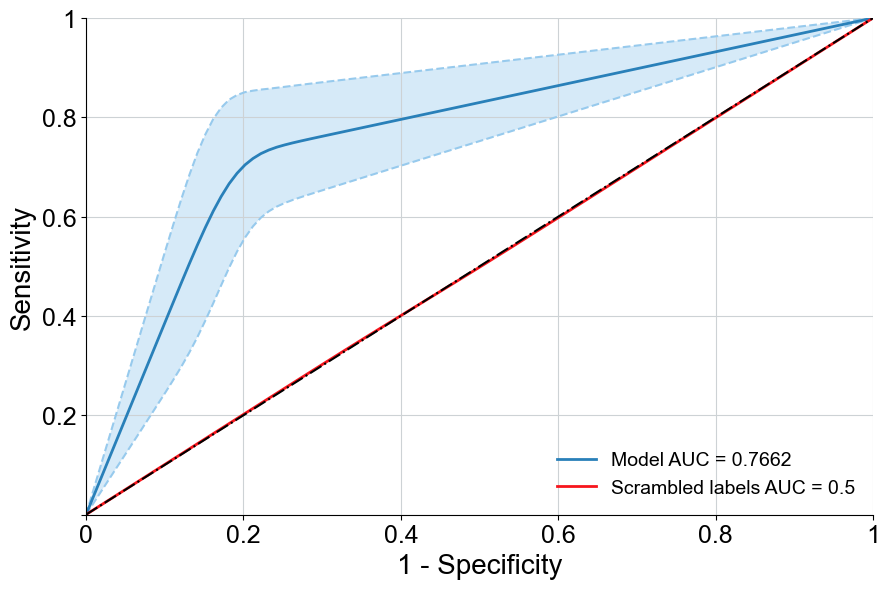

In [43]:
ml_plotting.plot_custom_roc_curve(rbf_ROC_AUC, rbf_ROC_chance, fname=path_res+ "/SVM_rbf/rbf_ROC_AUC_curve.png")

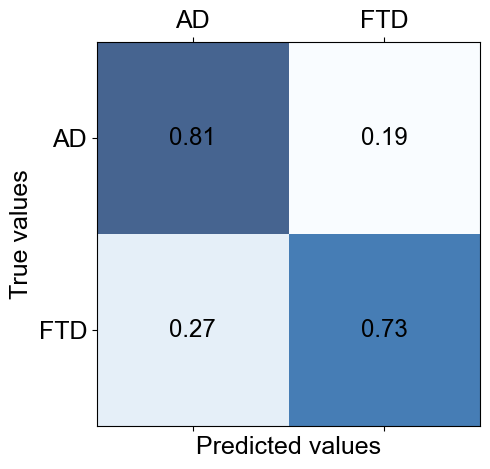

In [44]:
ml_plotting.plot_boostrap_CM(rbf_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_rbf/rbf_CM.png")

#### Permutation Feature importance

In [45]:
rbf_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=rbf_params, test_size=.3, n_repeats=1000, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [46]:
rbf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_rbf/rbf_PFI.csv")
rbf_fimp.sort_values('mean', ascending=False).head(10)

,predictor,mean,std
21,ace_vs,0.136953,0.010636
22,ace_lw,0.136288,0.010436
20,moca_lw,0.097127,0.013099
19,moca_vs,0.097127,0.013099
17,mmse_vs,0.087298,0.012723
18,mmse_lw,0.086502,0.012723
5,mmse_total,0.080423,0.013309
3,moca_total,0.036296,0.010702
0,year_birth,0.031210,0.016506
2,years_education,0.025978,0.014677


#### Unseen data

In [47]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [48]:
#Predict
svc_rbf = SVC(**rbf_params)
svc_rbf.fit(X_train, y_train)
y_pred = svc_rbf.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [49]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/SVM_rbf/rbf_unseen.csv")

In [50]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{rbf_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.5
Accuracy: 0.7664
Recall: 0.0
F1: 0.0
Precision:0.0
Unseen Data ROC score: 		0.5
Bootstrping test ROC score: 	0.7662


### SVM - Poly

#### Bootstrap

In [51]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

SVC(C=1.0203763218807211, class_weight='balanced', coef0=0, degree=1,
    gamma=4.878415166901823, kernel='poly', verbose=0)


Iterating: 100%|██████████████████| 5000/5000 [03:34<00:00, 23.31it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:3.574430759747823 minutes
empirical p-value: 0.0


In [52]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.758778
ROC_AUC        0.760439
Precision      0.494958
Recall         0.763583
Sensitivity    0.763583
Specificity    0.757295
F1             0.599254
dtype: float64

In [53]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.011859
ROC_AUC_ci        0.011831
Precision_ci      0.013859
Recall_ci         0.011777
Sensitivity_ci    0.011777
Specificity_ci    0.011883
F1_ci             0.013583
dtype: float64

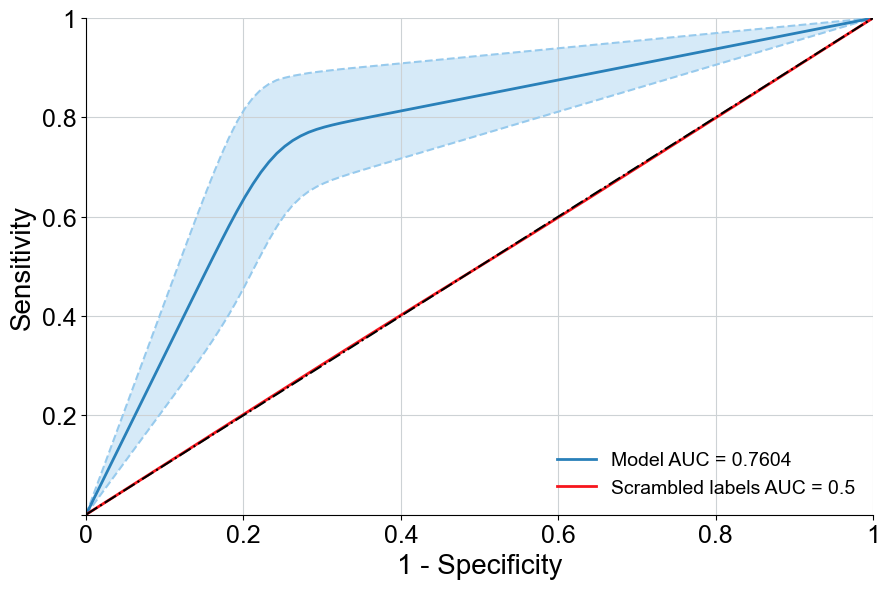

In [54]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

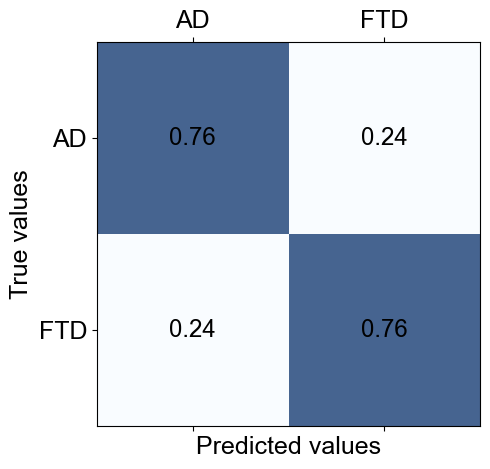

In [55]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [56]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=1000, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


,predictor,mean,std
21,ace_vs,0.119200,0.027588
0,year_birth,0.092256,0.018423
22,ace_lw,0.061167,0.015427
6,ifs_total_score,0.048412,0.014337
18,mmse_lw,0.048318,0.013581
33,income_s_9,0.033286,0.009480
5,mmse_total,0.025113,0.009382
2,years_education,0.021369,0.007006
17,mmse_vs,0.020582,0.017368
3,moca_total,0.018767,0.007660


#### Unseen data

In [57]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [58]:
poly = SVC(**poly_params)
poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [59]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [60]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.7841
Accuracy: 0.7757
Recall: 0.8
F1: 0.625
Precision:0.5128
Unseen Data ROC score: 		0.7841
Bootstrping test ROC score: 	0.7604


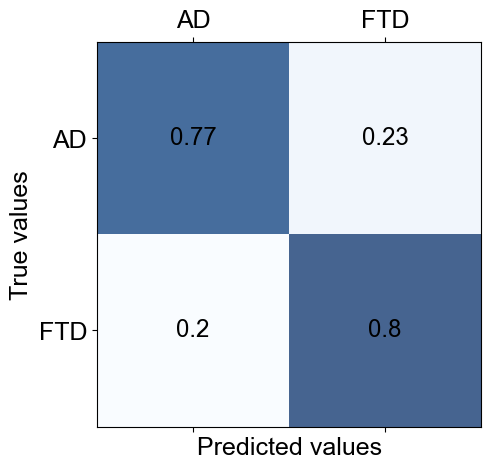

In [61]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### LightGBM

#### Bootstrap

In [62]:
lgb_Model_res, lgb_CI_df, lgb_Model_res_r, lgb_ROC_AUC, lgbCM, lgb_ROC_chance, lgb_empirical_p_value, _ = bc.Bootstrap_LGBM_classifier(
    data, 'diagnosis',  params=lgbm_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

Iterating: 100%|██████████████████| 5000/5000 [07:02<00:00, 11.83it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:7.045180888970693 minutes
empirical p-value: 0.0


In [63]:
lgb_Model_res.to_csv(path_res+ "/LightGBM/lgb_Model_res.csv", index=False)
lgb_Model_res.mean()

Accuracy       0.842809
ROC_AUC        0.872795
Precision      0.720651
Recall         0.552278
Sensitivity    0.552278
Specificity    0.932503
F1             0.622405
Efron_pR2      0.376319
dtype: float64

In [64]:
lgb_CI_df.to_csv(path_res+ "/LightGBM/lgb_CI_df.csv", index=False)
lgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010089,0.009236,0.012437,0.013783,0.013783,0.006954,0.013438,0.013429


In [65]:
lgb_Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+"/LightGBM/lgb_CI_df.csv", index=False)
lgb_Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
9,ifs_total_score,126.7558,12.075004
34,year_birth,108.4100,10.868538
27,moca_total,70.8794,10.576352
30,npi_total,62.2668,13.141254
22,mini_sea_total,55.2714,13.173627
35,years_education,49.5204,9.562734
31,npi_total_caregiver,39.3566,12.560071
28,moca_vs,37.5222,12.776860
5,cognition,36.7680,12.556724
1,ace_lw,31.7956,10.741922


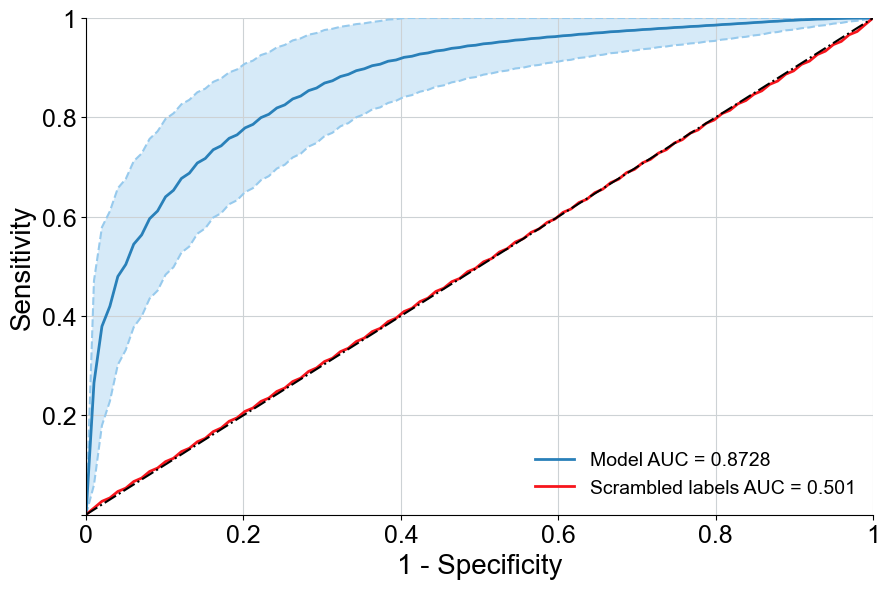

In [66]:
ml_plotting.plot_custom_roc_curve(lgb_ROC_AUC, lgb_ROC_chance, fname=path_res+ "/LightGBM/lgb_ROC.png")

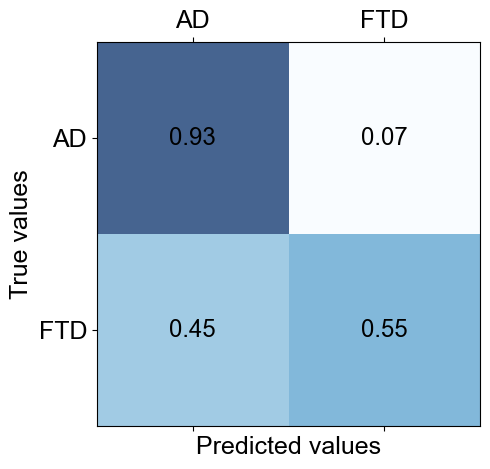

In [67]:
ml_plotting.plot_boostrap_CM(lgbCM, labels=['AD', 'FTD'],fname=path_res+ "/LightGBM/lgb_CM.png")

#### Permutation Feature importance

In [68]:
lgb_fimp = bc.permutation_FIMP( data, 'diagnosis', lightgbm.LGBMClassifier(), params=lgbm_params, test_size=.3, n_repeats=1000, random_state=123)
lgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/LightGBM/lgb_PFI.csv")
lgb_fimp.sort_values('mean', ascending=False).head(10)

,predictor,mean,std
0,year_birth,0.087703,0.019116
6,ifs_total_score,0.078454,0.017864
3,moca_total,0.015830,0.008144
2,years_education,0.015621,0.004882
10,npi_total,0.007913,0.004006
33,income_s_9,0.005754,0.002648
7,mini_sea_total,0.004706,0.003286
12,marital_status,0.003793,0.003450
15,household_income,0.001985,0.001516
16,Job_status,0.001607,0.000932


#### Unseen data

In [69]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [70]:
lgb = lightgbm.LGBMClassifier(**lgbm_params)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [71]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/LightGBM/lgb_PFI.csv")

In [72]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.8217
Accuracy: 0.8972
Recall: 0.68
F1: 0.7556
Precision:0.85
Unseen Data ROC score: 		0.8217
Bootstrping test ROC score: 	0.8728


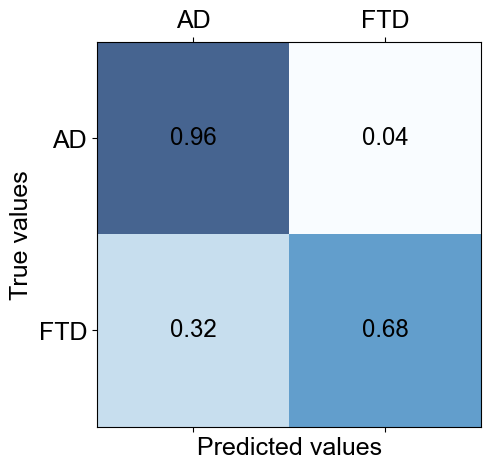

In [73]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])

### XGBoost

#### Bootstrap

In [74]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=5000, chance_model=True)

Iterating: 100%|██████████████████| 5000/5000 [18:44<00:00,  4.44it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:18.748990126450856 minutes
empirical p-value: 0.0


In [75]:
xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.844743
ROC_AUC        0.871889
Precision      0.721635
Recall         0.564552
Sensitivity    0.564552
Specificity    0.931244
F1             0.630379
Efron_pR2      0.385305
dtype: float64

In [76]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
9,ifs_total_score,155.4218,13.984255,4.964431,0.721443
28,year_birth,140.2908,13.847664,5.158680,0.822091
29,years_education,110.7962,14.763044,1.993098,0.306833
24,npi_total,87.8010,13.790600,2.269059,0.411325
21,moca_total,82.6718,12.846318,3.490489,0.590161
19,mmse_total,60.8128,13.426489,1.240715,0.255518
17,mini_sea_total,58.6348,12.262948,1.693395,0.339764
25,npi_total_caregiver,55.3194,10.777060,2.584658,0.450369
22,moca_vs,46.1316,11.611789,1.576353,0.421251
27,sex,44.1300,10.923835,1.368604,0.254547


In [77]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.010038,0.009264,0.012423,0.013743,0.013743,0.007014,0.01338,0.01349


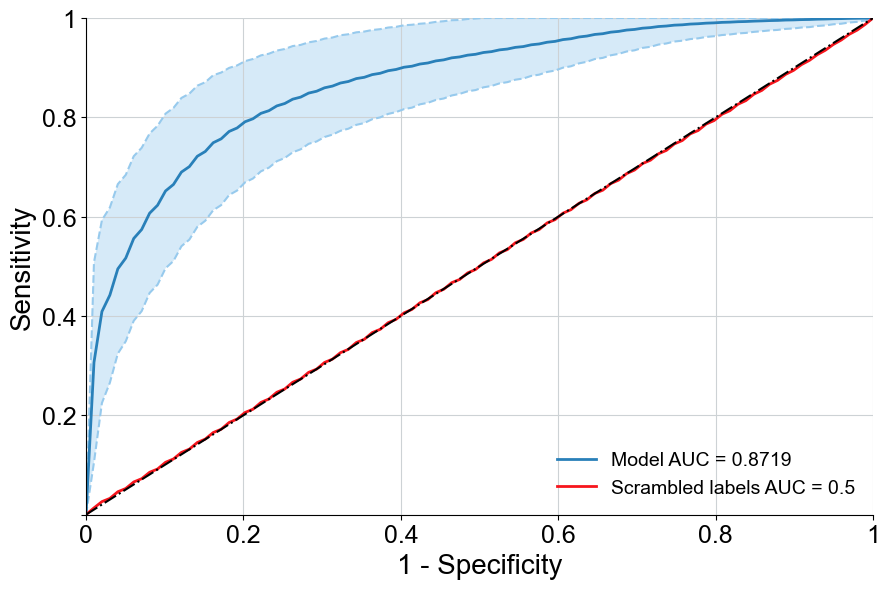

In [78]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

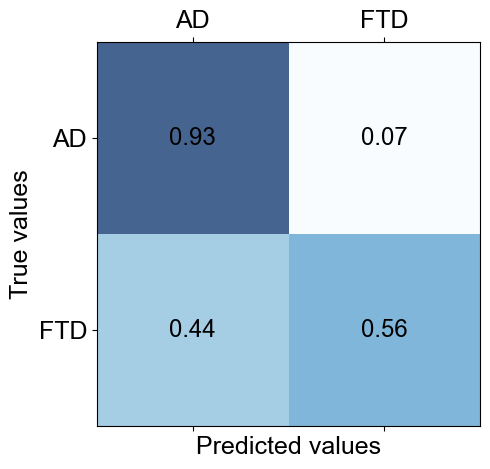

In [79]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [80]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
xgb_fimp.sort_values('mean', ascending=False).head(10)

,predictor,mean,std
6,ifs_total_score,0.114083,0.021043
0,year_birth,0.081263,0.017744
2,years_education,0.017412,0.004785
3,moca_total,0.010214,0.007142
10,npi_total,0.008578,0.003787
15,household_income,0.007915,0.003695
4,aceiii_total,0.006352,0.001771
12,marital_status,0.005056,0.002580
33,income_s_9,0.003148,0.001258
16,Job_status,0.002533,0.001019


#### Unseen data

In [81]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']]
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']]

In [82]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)
cm = np.round(confusion_matrix(y_test, y_pred), 4)

In [83]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec, cm]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision', 'CM']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [84]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.7878
Accuracy: 0.8879
Recall: 0.6
F1: 0.7143
Precision:0.8824
Unseen Data ROC score: 		0.7878
Bootstrping test ROC score: 	0.8719


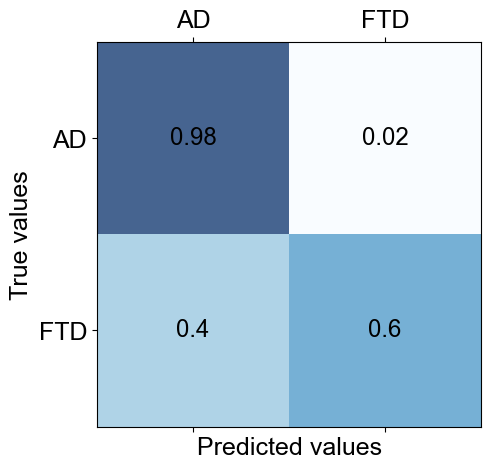

In [85]:
unseen_cm = { 'TP':cm[0,0], 'FN':cm[0,1],'FP':cm[1,0],'TN':cm[1,1]}
ml_plotting.plot_boostrap_CM(unseen_cm, labels=['AD', 'FTD'])